In [167]:
import lassonet
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from RKHS import SparseVFC
from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix
import pandas as pd

In [168]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import *
from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [169]:
k_nei=10
K=3
L=2
normalized=1

In [170]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())

2.0.1+cpu
None
False
0


In [171]:
data_path='data/'
result_path='results/'

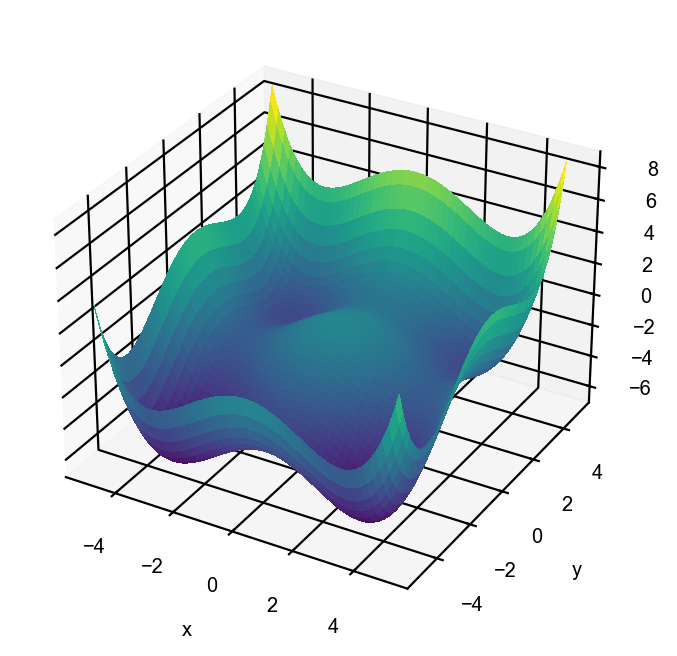

In [172]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the double well potential function
def four_well_potential(x, y):
    return 0.05*x**4-x**2+0.05*y**4-(y-0.5)**2

# Define the range of x and y values to plot


x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)

# Create a 2D grid of x and y values
X, Y = np.meshgrid(x, y)

# Calculate the potential energy at each point in the grid
Z = 0.5*four_well_potential(X, Y)

# Create a 3D surface plot of the potential energy
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Potential Energy')

plt.show()

# 动力学采样
这种采样再重复利用训练数据的情况下似乎是可以的，但是在不重复利用的训练模式下好像不行

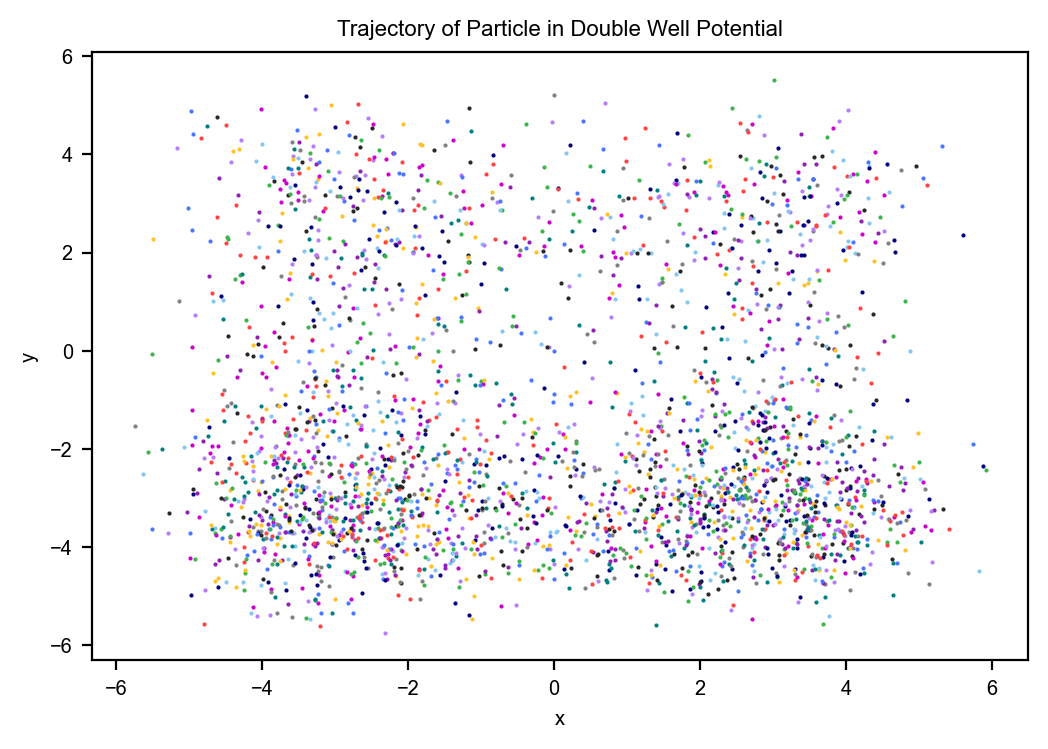

In [173]:
# Define the parameters of the simulation
k1 = 0.05  
k2= 0.05
T = 0.8  # Temperature
gamma = 0.1  # Damping coefficient
dt = 0.01  # Time step
tmax = 100.0  # Maximum simulation time
x0 = np.array([0, 0.0])  # Initial position

# Define the double well potential
def potential(x):
    return k1*x[0]**4-x[0]**2+k2*x[1]**4-(x[1]-0.5)**2

# Define the gradient of the potential
def gradient(x):
    return np.array([4*k1*x[0]**3-2*x[0],4*k2*x[1]**3-2*x[1]+1])

# Define the stochastic force
def stochastic_force(x):
    return 0.08*np.sqrt(2.0 * gamma * T / dt) * np.random.normal(size=2)

# Initialize the particle position and velocity


# Initialize the time and trajectory arrays

trajs=[]

for tl in range(60):
    # Perform the simulation using the Euler-Maruyama method
    
    x = x0
    v = np.zeros(2)
    t = np.arange(0.0, tmax, dt)
    
    tr = np.zeros((len(t), 2))
    tr[0] = x
    
    tr_U= np.zeros((len(t), 1))
    tr_U[0]=potential(x)

    for i in range(1, len(t)):
        # Calculate the deterministic force
        f_d = -gradient(x)

        # Calculate the stochastic force
        f_s = stochastic_force(x)

        # Calculate the position using the Euler method
        x += (f_d*dt + f_s)

        # Update the trajectory array
        tr[i] = x
        tr_U[i] = potential(x)
        
    
    #trajs.append(tr[::200, :])

    trajs.append(np.hstack((tr[::200, :],tr_U[::200,:])))
    # Plot the trajectory of the particle
    plt.scatter(tr[::200, 0], tr[::200, 1],s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Trajectory of Particle in Double Well Potential')
plt.show()


In [174]:
X_major=np.concatenate(trajs,axis=0)+4

# 这一步是砍掉z太大的离群点
# X_major = X_major[X_major[:,2]<=6,:]

n_samples=X_major.shape[0]

X_minor=0.1*np.random.randn(n_samples,8)
X=np.hstack((X_major,X_minor))
color_label=np.zeros((n_samples))
color_label[np.argsort(X[:,0])]=np.arange(n_samples)

In [175]:
X.shape

(3000, 11)

# 均匀采样

In [176]:

# n_samples=3000
# X_minor=0.1*np.random.randn(n_samples,7)

# roi=np.linspace(-5,5,10000)

# x1=np.random.choice(roi,n_samples)
# x2=np.random.choice(roi,n_samples)
# color_label=np.zeros((n_samples))
# color_label[np.argsort(x2)]=np.arange(n_samples)

# x3 = 0.05*x1**4-x1**2+0.05*x2**4-(x2-0.5)**2


# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
# plt.show()

# X_major=np.array([x1,x2,x3]).T
# X=np.hstack((X_major,X_minor))


In [177]:
A = kneighbors_graph(X, 10, mode='connectivity', include_self=True)

def embed_dist_compare(A,X,em_X):
    dist_ratios=[]
    for ori_inds in np.split(A.indices, A.indptr)[1:-1]:
        dist_r=[]
        self_ind=ori_inds[0]
        for nei_k in range(1,len(ori_inds)):

            dEu=np.linalg.norm(X[self_ind,:]-X[ori_inds[nei_k],:])


            em_dEu=np.linalg.norm(em_X[self_ind,:]-em_X[ori_inds[nei_k],:]) 
            dist_r.append(dEu/em_dEu)
#         print(np.std(dist_r)/np.mean(dist_r))
        dist_ratios.append(np.std(dist_r)/np.mean(dist_r))
    return np.array(dist_ratios)

# PCA

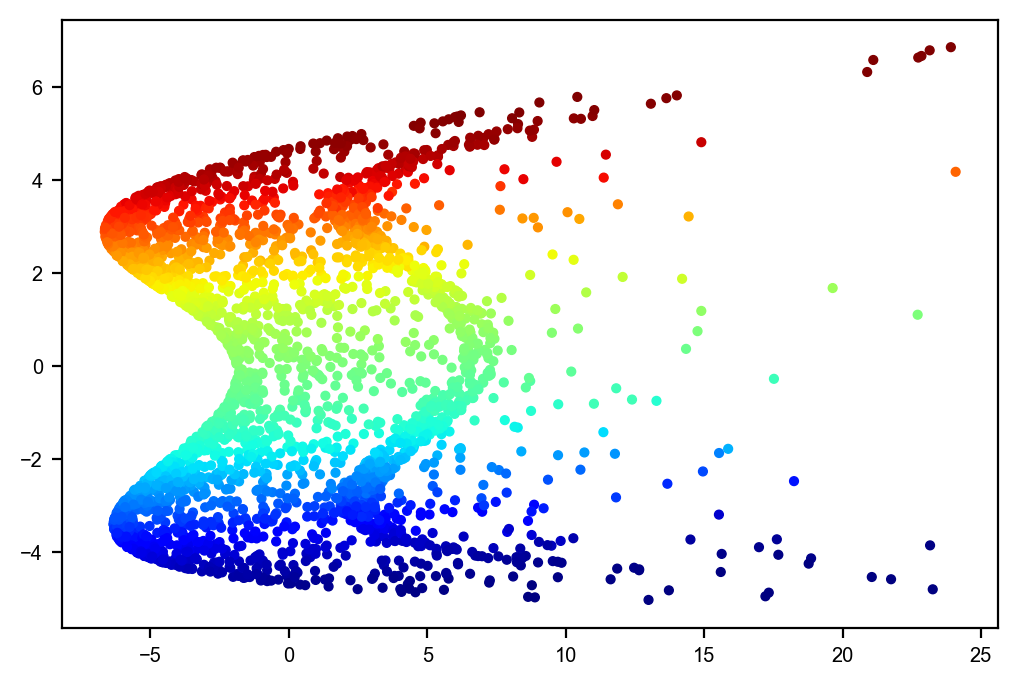

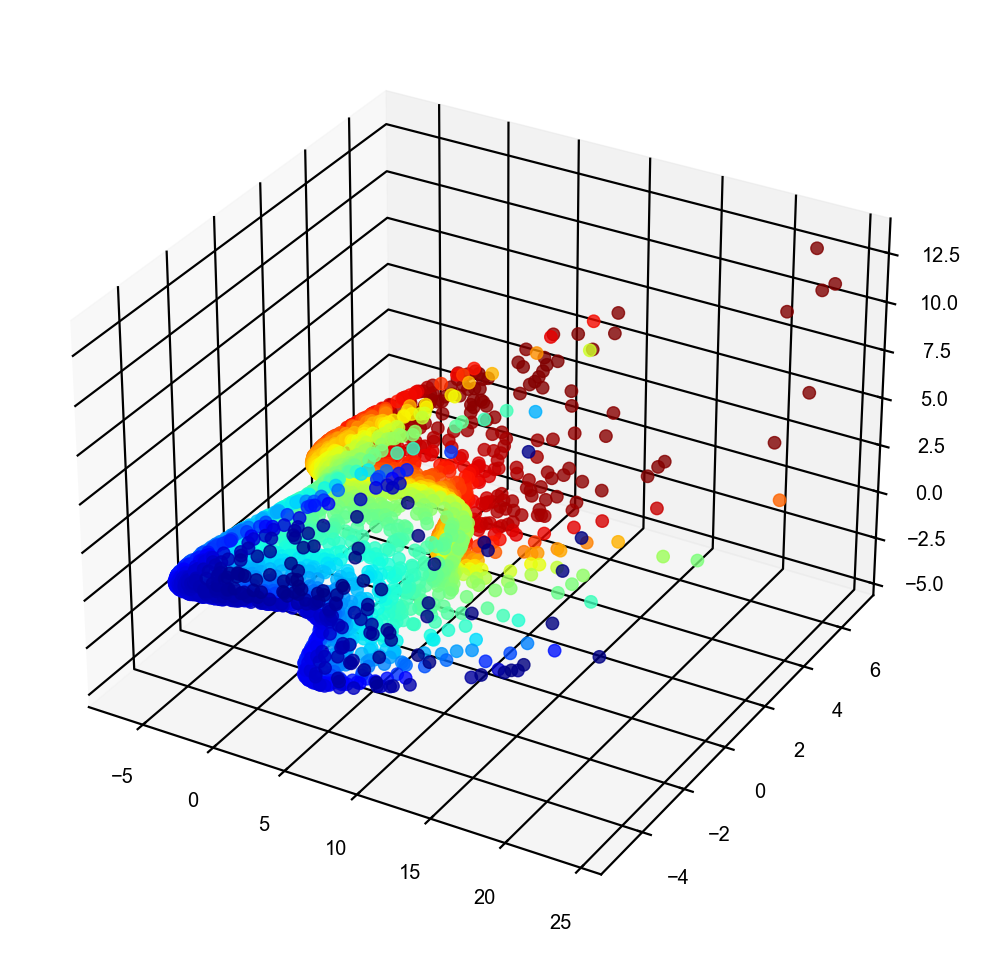

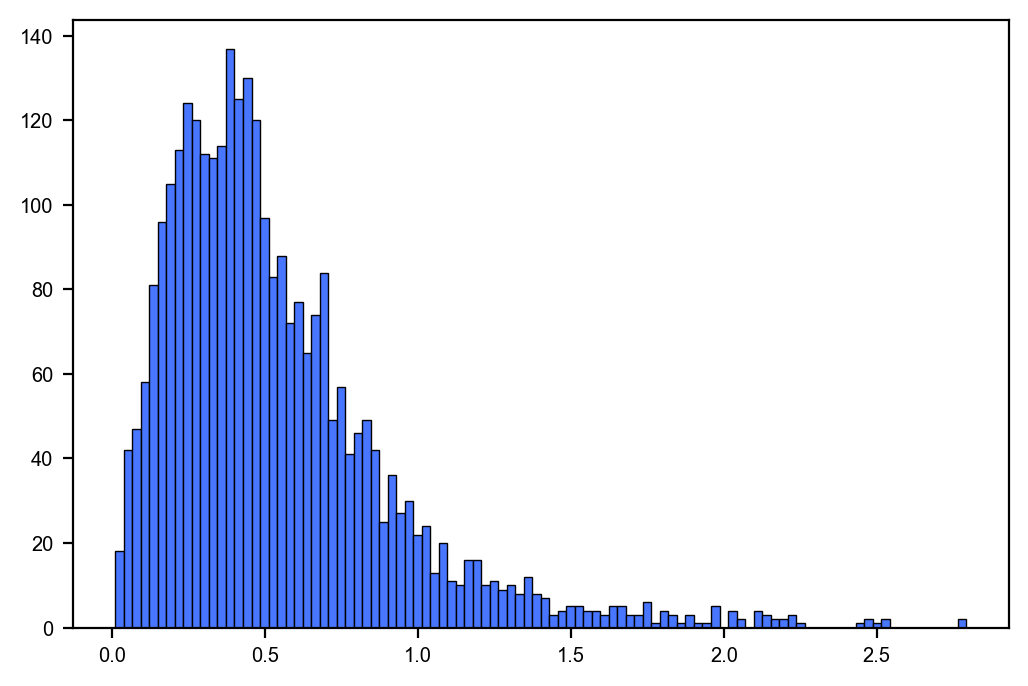

In [178]:
pca=PCA(n_components=3).fit(X)
X_pca=pca.transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],s=10,c=color_label,cmap=plt.cm.jet)
plt.show()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X_pca[:, 0],X_pca[:, 1], X_pca[:, 2], c=color_label, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.show()

ratio_compare=embed_dist_compare(A,X,X_pca[:,:2])
plt.hist(ratio_compare,bins=100,edgecolor='black')
plt.show()

# LassoNet Gaussian Embedding
如果改变lambda后不重启loader，这里`epochs`应该非常大

In [179]:

epochs = 5000
nsamples = 5
learning_rate = 1e-3
seed = 0
# n_workers = 4
K = K# !!!!!!!!!! K should be large enough


if seed is not None:
    reset_seeds(seed)

A=A.astype(np.float32)
X=X.astype(np.float32)
X=X/np.mean(np.abs(X),axis=0)
# X=adata.X.A
#--------do not normalize X
# scaler=StandardScaler()#
# X=scaler.fit_transform(X0_ori)
z=color_label

n = A.shape[0]
train_nodes, val_nodes = train_test_split(n, train_ratio=1.0)
A_train = A[train_nodes, :][:, train_nodes]
X_train = X[train_nodes]
z_train = z[train_nodes]
A_val = A[val_nodes, :][:, val_nodes]
X_val = X[val_nodes]
z_val = z[val_nodes]

train_data = AttributedGraph(A_train, X_train, z_train, K)
val_data = AttributedGraph(A_val, X_val, z_val, K)

L = L
# L = np.load('results/latent_dim.npy')
encoder = LassoEncoder(X.shape[1], L, M=10)

In [180]:
optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)

iterations = epochs #// n_workers
dataset = GraphDataset(train_data, nsamples, iterations)
loader = DataLoader(
    dataset,
    batch_size=1,
#     num_workers=n_workers,
    worker_init_fn=reset_seeds,
    collate_fn=lambda args: args,
)

In [181]:

# for batch_idx, data in enumerate(loader):
#     encoder.train()
#     optimizer.zero_grad()

#     loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
    
#     if batch_idx% 10 == 0:
#         print(f"batch = {batch_idx}, loss = ",loss)
#     loss.backward()
#     optimizer.step()

# Lassonet风格的训练
需要给定一个`lambda_seq`表示你希望使用的λ序列  
在该序列前cat了一个0，表示我们总是先训练不带L1正则项的一般模型，然后对每一个lambda逐一训练  
这里设置了当剩余3个被选择features时提前终止

In [182]:
# lambda_seq = np.concatenate(([0],np.linspace(0.5,1,2)))
# for lambda_ in lambda_seq:
#     encoder.lambda_ =lambda_
#     for batch_idx, data in enumerate(loader):
#         encoder.train()
#         optimizer.zero_grad()

#         loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])
        
#         if batch_idx% 10 == 0:
#             print(f"lambda = {lambda_}, batch = {batch_idx}, loss = ",loss, f" skip_l1 = {encoder.l1_regularization_skip()}, feature_number = {encoder.selected_count()}")
#         loss.backward()
#         optimizer.step()
#         encoder.prox()
#         if encoder.selected_count() == 3:
#             break

# 这是更新之后的训练模式
这是全自动的，带有提前停止。可以调dim，会让训练停在剩余dim个feature

In [183]:
# 每次变lambda之后不重启dataloader

dim = 3

hist_opt = np.inf
hist_opt_idx = 0
encoder.lambda_ = 0
for batch_idx, data in enumerate(loader):
    encoder.train()
    optimizer.zero_grad()

    loss = encoder.compute_loss(data[0][0],data[0][1],data[0][2],data[0][3],data[0][4],data[0][5])

    if batch_idx == 0:
            hist_opt = loss
            hist_opt_idx = batch_idx

    # early stopping
    if loss < hist_opt:
        hist_opt = loss
        hist_opt_idx = batch_idx
    elif hist_opt_idx+10 < batch_idx:
        if encoder.lambda_:
            encoder.lambda_ *= 1.1
        else:
             encoder.lambda_ = 0.1
        hist_opt_idx = batch_idx
        hist_opt = loss

    if batch_idx% 10 == 0:
        print(f"lambda = {encoder.lambda_}, batch = {batch_idx}, loss = ",loss, f" skip_l1 = {encoder.l1_regularization_skip()}, feature_number = {encoder.selected_count()}")
    loss.backward()
    optimizer.step()
    encoder.prox()

    if encoder.selected_count() <= dim:
        break

lambda = 0, batch = 0, loss =  tensor(3.4393e+10, grad_fn=<DivBackward0>)  skip_l1 = 8.303140640258789, feature_number = 11
lambda = 0, batch = 10, loss =  tensor(4.3704e+09, grad_fn=<DivBackward0>)  skip_l1 = 8.140130996704102, feature_number = 11
lambda = 0, batch = 20, loss =  tensor(6.3769e+08, grad_fn=<DivBackward0>)  skip_l1 = 8.038337707519531, feature_number = 11
lambda = 0, batch = 30, loss =  tensor(4.5358e+08, grad_fn=<DivBackward0>)  skip_l1 = 7.997186660766602, feature_number = 11
lambda = 0, batch = 40, loss =  tensor(4.2991e+08, grad_fn=<DivBackward0>)  skip_l1 = 7.986448287963867, feature_number = 11
lambda = 0, batch = 50, loss =  tensor(4.2291e+08, grad_fn=<DivBackward0>)  skip_l1 = 7.989428520202637, feature_number = 11
lambda = 0, batch = 60, loss =  tensor(4.2128e+08, grad_fn=<DivBackward0>)  skip_l1 = 7.998805999755859, feature_number = 11
lambda = 0, batch = 70, loss =  tensor(4.1577e+08, grad_fn=<DivBackward0>)  skip_l1 = 8.011479377746582, feature_number = 11
l

In [184]:
(torch.norm(encoder.skip.weight.data, p=2, dim=0).numpy()==0).sum()

8

In [185]:
(torch.norm(encoder.linear1.weight.data, p=2, dim=0).numpy()==0).sum()

8

用`encoder.input_mask()`可以查看feature是否被选用，这里表示，前三个坐标被保留，后面八个噪声项被滤去

In [186]:
encoder.input_mask()

tensor([ True,  True,  True, False, False, False, False, False, False, False,
        False])

In [187]:
torch.save(encoder,'encoder.pt')
# torch.save(encoder,'results/L='+str(L)+',K='+str(K)+'.pt')

In [188]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

In [189]:
cRc_arr=[]
cRc_arr_eu=[]

for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu

    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)

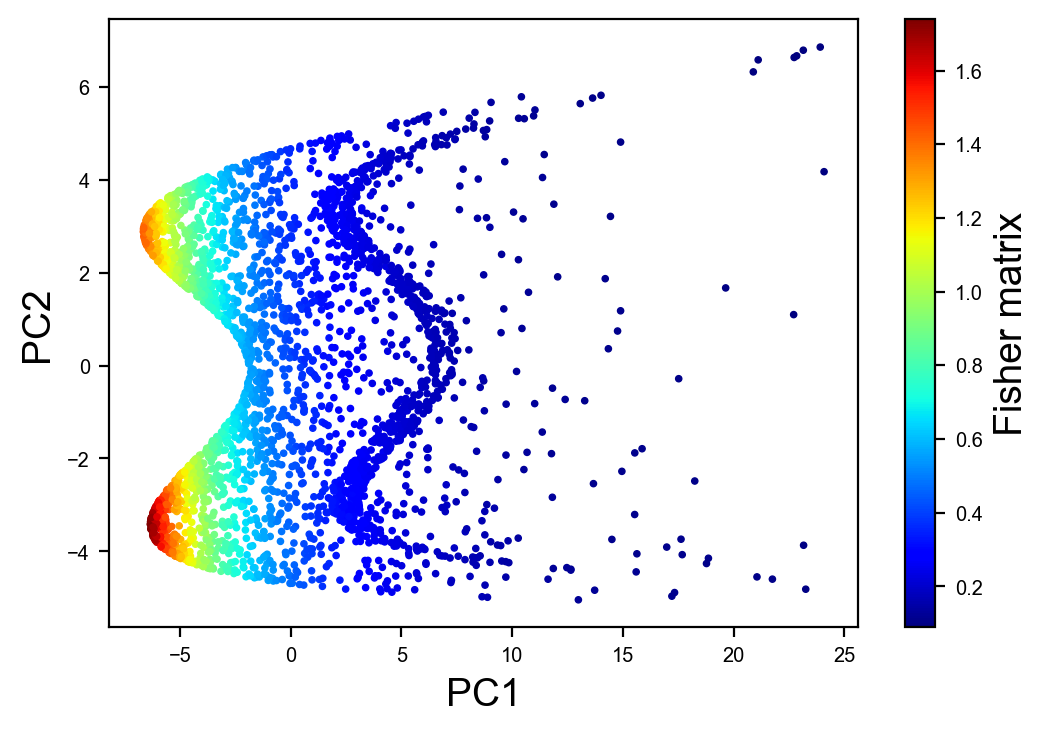

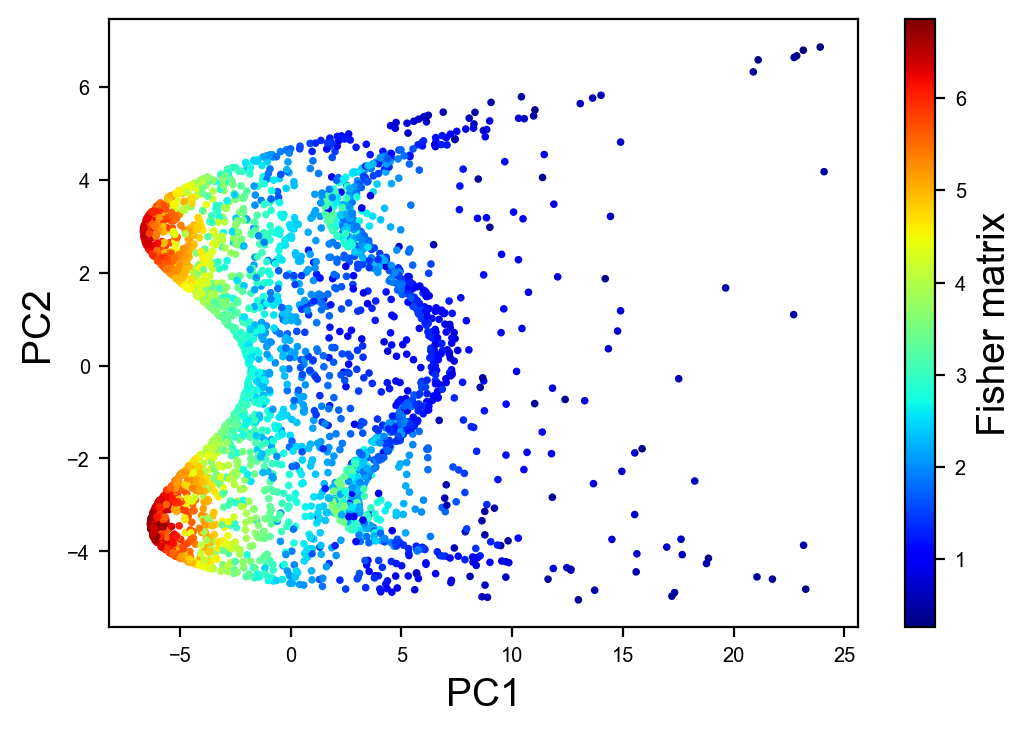

In [190]:
for i in range(L):
    plt.scatter(X_pca[:,0],X_pca[:,1],s=5,c=Fisher_g[:,i,i],cmap=plt.cm.jet)
    plt.xlabel('PC1',fontsize=14)
    plt.ylabel('PC2',fontsize=14)
    
    clb=plt.colorbar()
    clb.ax.set_ylabel('Fisher matrix',fontsize=14)
    plt.savefig('g_'+str(i)+'.png')
    plt.show()

# 通过该网络能够复现四阱函数的曲率图像

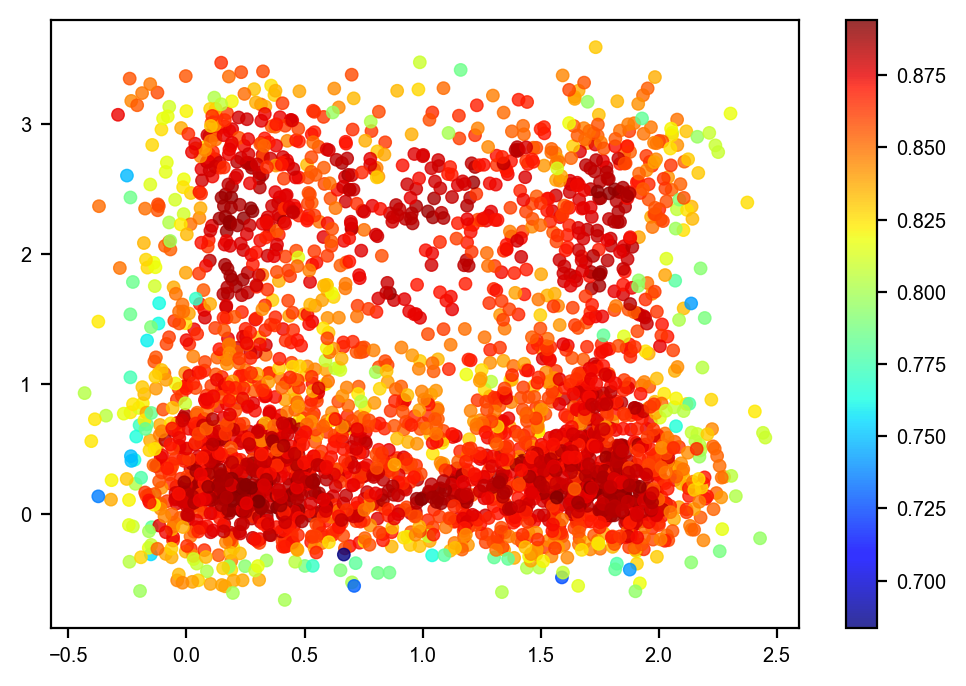

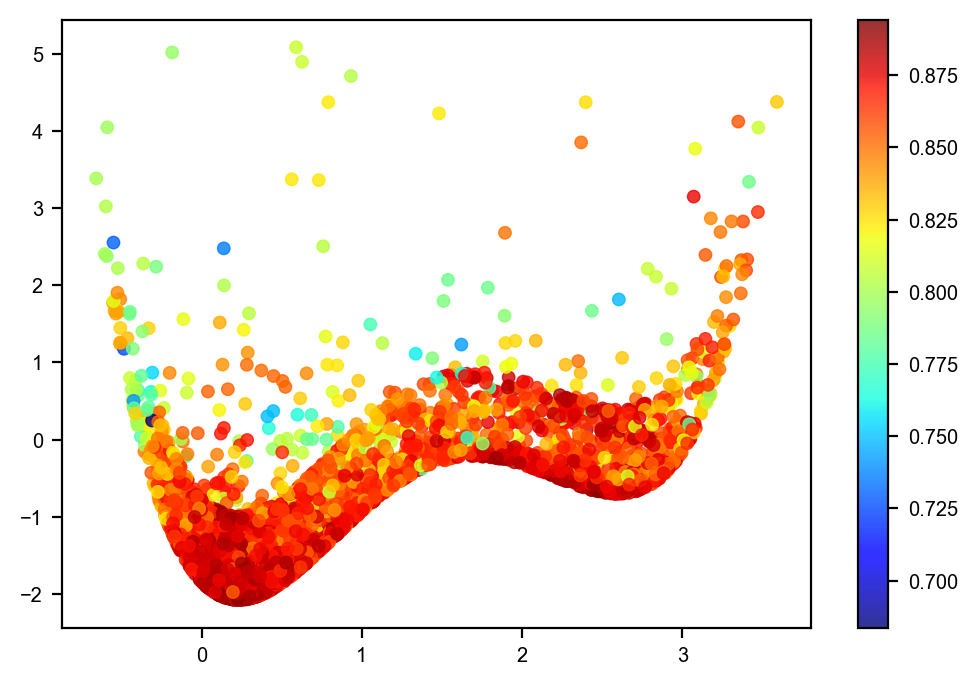

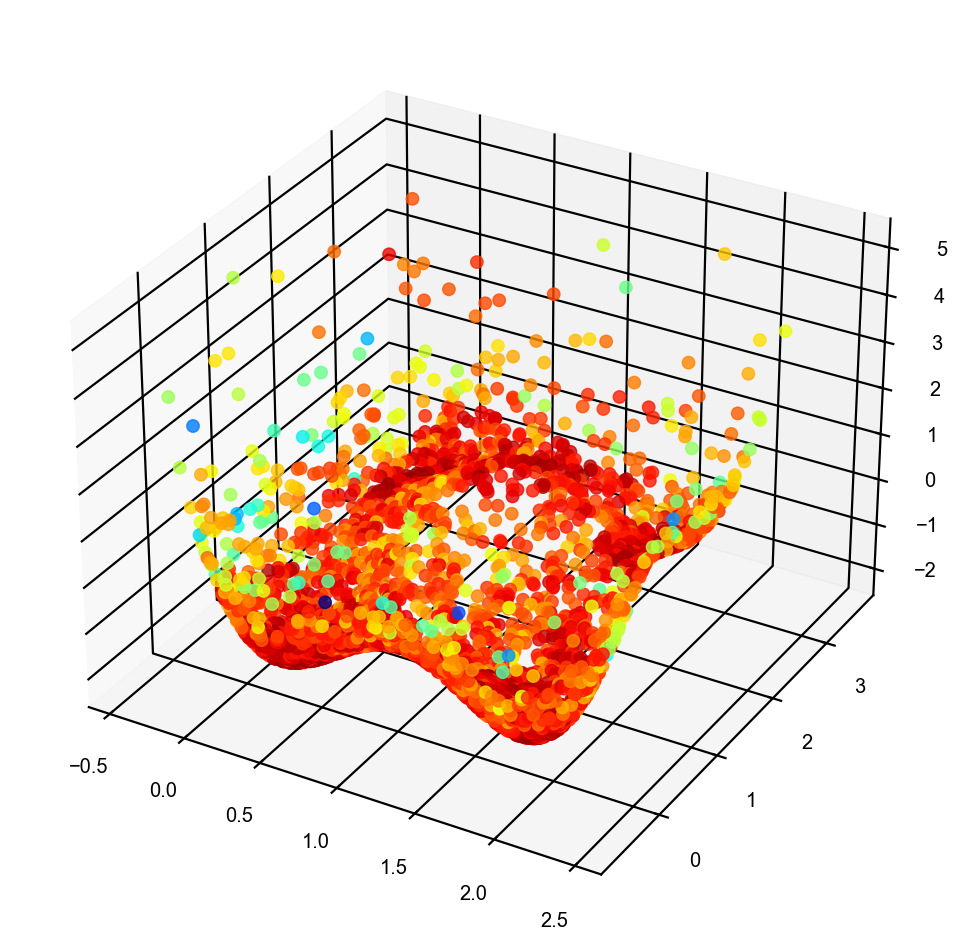

In [191]:
plt.scatter(X[:, 0],X[:, 1], c=cRc_arr_eu, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.savefig("4well 1")
plt.show()

plt.scatter(X[:, 1],X[:, 2], c=cRc_arr_eu, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.savefig("4well 2")
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X[:, 0],X[:, 1], X[:, 2], c=cRc_arr_eu, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.savefig("4well 3")
plt.show()

In [192]:
cell_nei = A.indices.reshape([-1,10])
cell_nei

nei_w=[]
rho_arr=[]
row =np.array([np.ones((k_nei,))*i for i in range(X.shape[0])]).flatten()
col=cell_nei.flatten()
w_val=np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
dc=np.amax(w_val)
for i in range(cell_nei.shape[0]):
    dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/rho)
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)

cRc_arr_eu = np.array(cRc_arr_eu)

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

cRc_arr_eu_smooth = smooth_func(cRc_arr_eu)

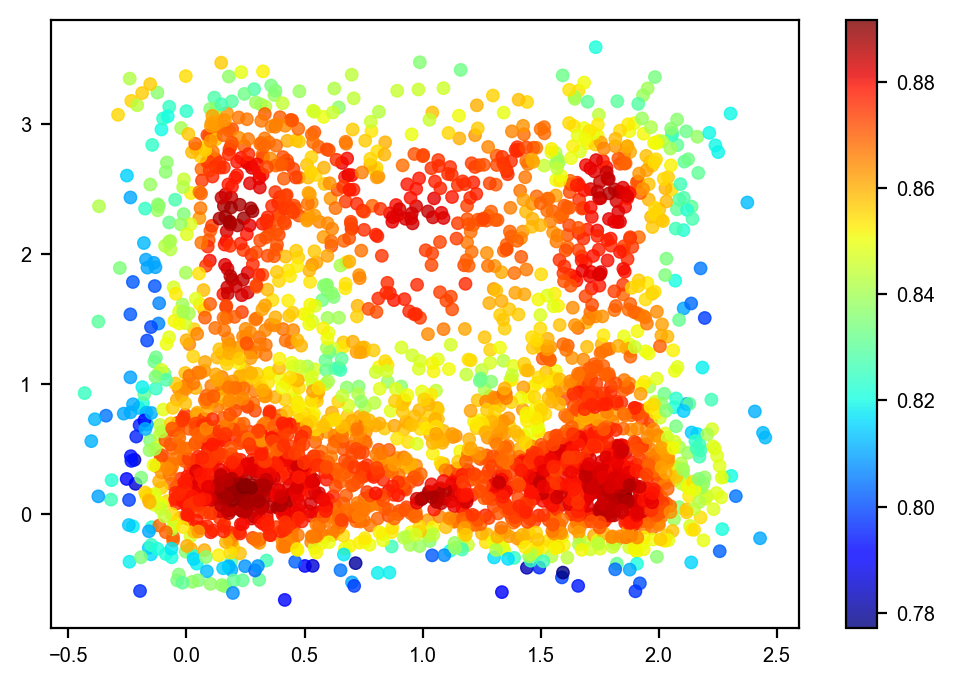

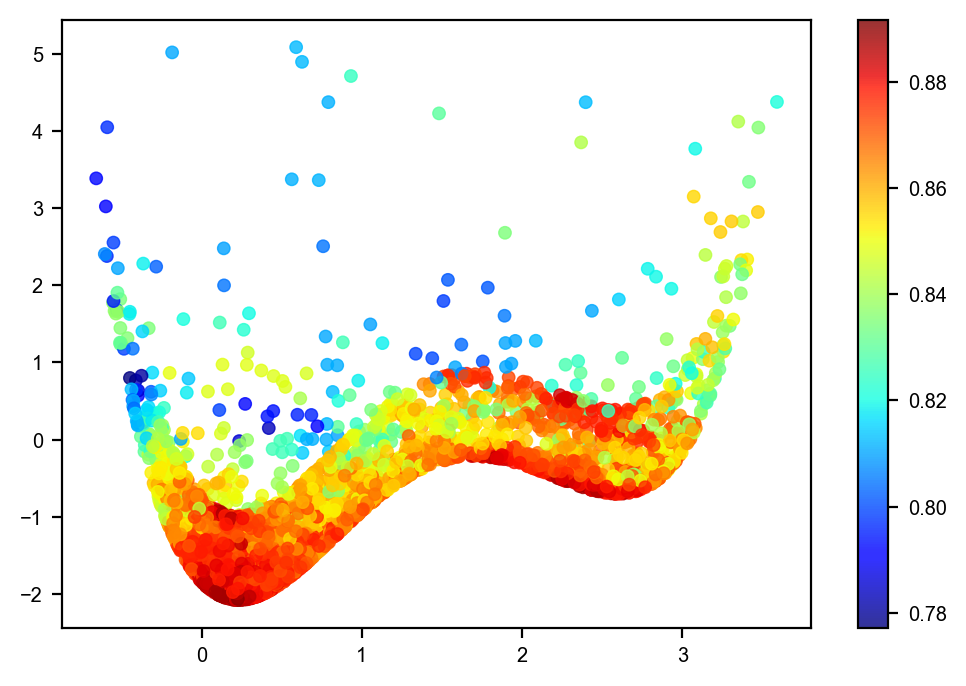

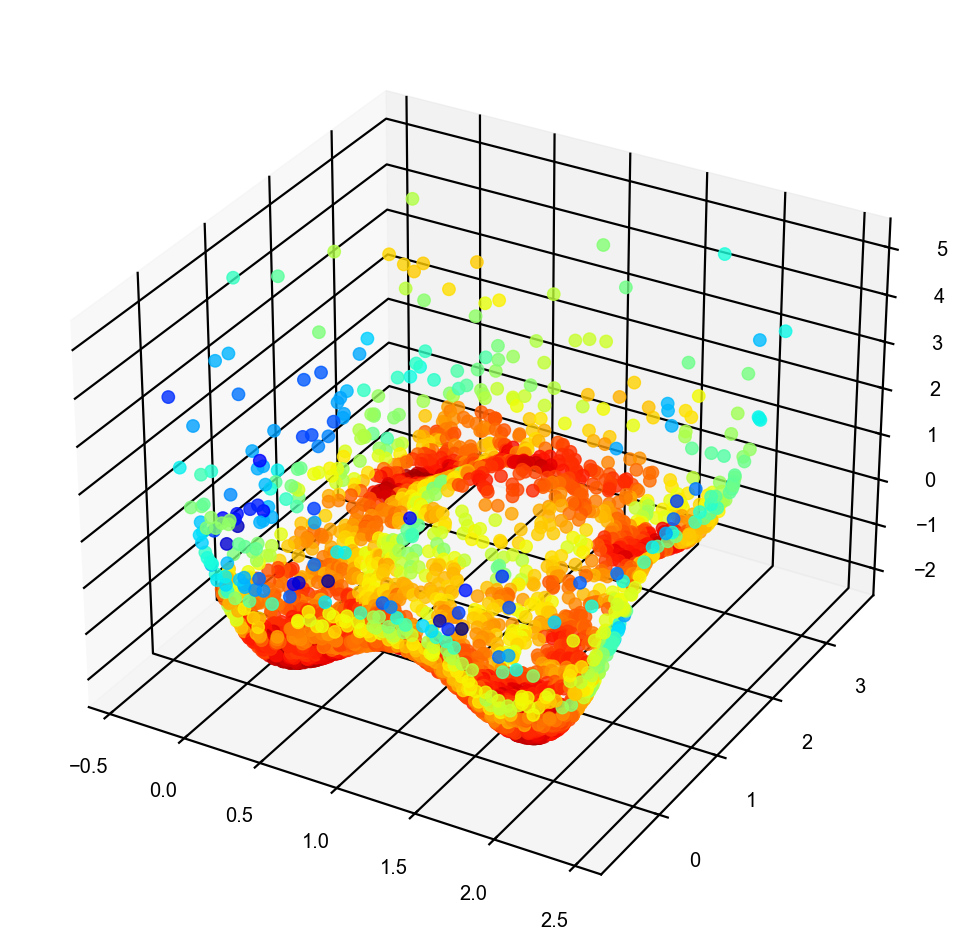

In [193]:
plt.scatter(X[:, 0],X[:, 1], c=cRc_arr_eu_smooth, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.savefig("4well smooth 1")
plt.show()

plt.scatter(X[:, 1],X[:, 2], c=cRc_arr_eu_smooth, s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.savefig("4well smooth 2")
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X[:, 0],X[:, 1], X[:, 2], c=cRc_arr_eu_smooth, s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.savefig("4well smooth 3")
plt.show()

# Mask
对于这个数据，我需要截断掉曲率后5%的，才能得到比较清晰的曲率图像。

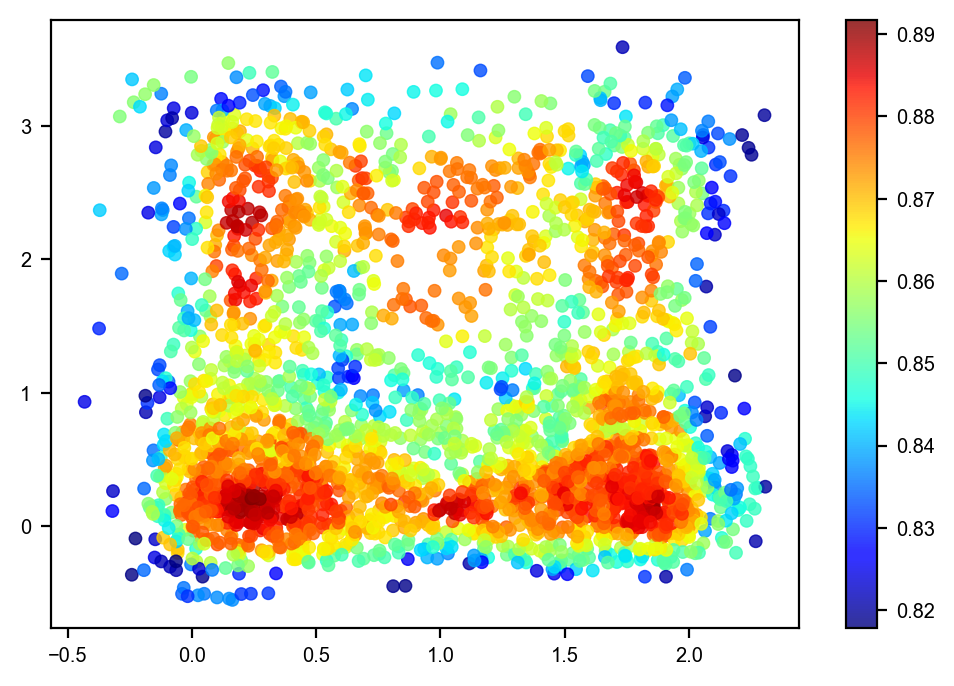

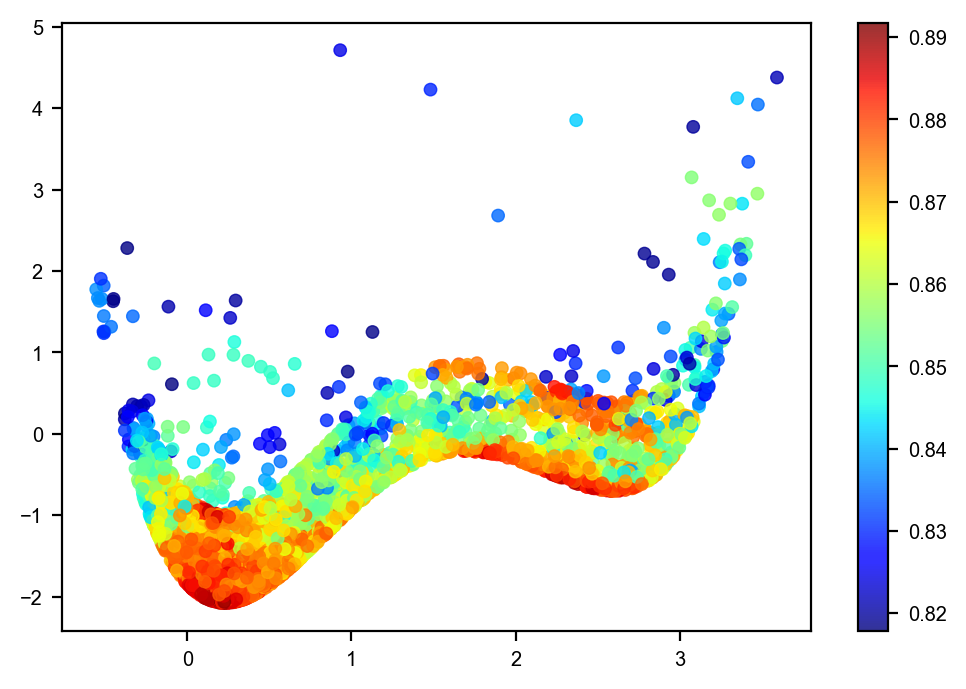

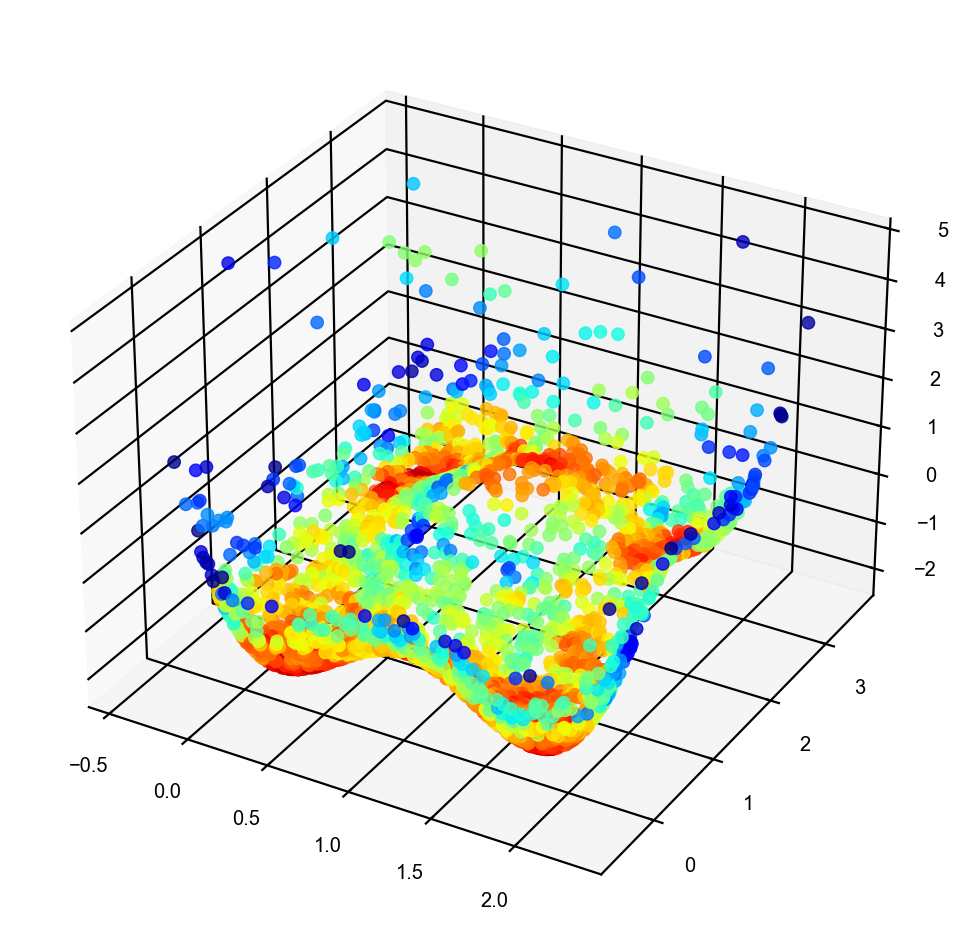

In [197]:
t = np.quantile(cRc_arr_eu_smooth,0.03)
idx = (cRc_arr_eu_smooth > t)

plt.scatter(X[:, 0][idx],X[:, 1][idx], c=cRc_arr_eu_smooth[idx], s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.savefig("4well smooth mask 1")
plt.show()

plt.scatter(X[:, 1][idx],X[:, 2][idx], c=cRc_arr_eu_smooth[idx], s=20, alpha=0.8,cmap=plt.cm.jet)
plt.colorbar()
plt.savefig("4well smooth mask 2")
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X[:, 0][idx],X[:, 1][idx], X[:, 2][idx], c=cRc_arr_eu_smooth[idx], s=20, alpha=0.8,cmap=plt.cm.jet
)
plt.savefig("4well smooth mask 3")
plt.show()

# 修正尝试
另一个考虑是，我们可以在一开始就扔掉z太大的outliers再训练试一下